In [2]:
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Deque

In [3]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [4]:
train = pd.read_csv(f'input/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [5]:
original_len = len(train)
train.set_index(['Patient', 'Weeks'], inplace=True, drop=False)
assert original_len == len(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1549 entries, ('ID00007637202177411956430', -4) to ('ID00426637202313170790466', 59)
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 101.6+ KB


In [6]:
train.head(20)

Patient  Weeks   FVC  \
Patient                   Weeks                                           
ID00007637202177411956430 -4     ID00007637202177411956430     -4  2315   
                           5     ID00007637202177411956430      5  2214   
                           7     ID00007637202177411956430      7  2061   
                           9     ID00007637202177411956430      9  2144   
                           11    ID00007637202177411956430     11  2069   
                           17    ID00007637202177411956430     17  2101   
                           29    ID00007637202177411956430     29  2000   
                           41    ID00007637202177411956430     41  2064   
                           57    ID00007637202177411956430     57  2057   
ID00009637202177434476278  8     ID00009637202177434476278      8  3660   
                           9     ID00009637202177434476278      9  3610   
                           11    ID00009637202177434476278     11  3895   
                           13    ID00009637202177434476278     13  3759   
                           15    ID00009637202177434476278     15  3639   
                           22    ID00009637202177434476278     22  3578   
                           33    ID00009637202177434476278     33  3625   
                           45    ID00009637202177434476278     45  3390   
                           60    ID00009637202177434476278     60  3214   
ID00010637202177584971671  0     ID00010637202177584971671      0  3523   
                           1     ID00010637202177584971671      1  3373   

                                   Percent  Age   Sex SmokingStatus  
Patient                   Weeks                                      
ID00007637202177411956430 -4     58.253649   79  Male     Ex-smoker  
                           5     55.712129   79  Male     Ex-smoker  
                           7     51.862104   79  Male     Ex-smoker  
                           9     53.950679   79  Male     Ex-smoker  
                           11    52.063412   79  Male     Ex-smoker  
                           17    52.868646   79  Male     Ex-smoker  
                           29    50.327126   79  Male     Ex-smoker  
                           41    51.937594   79  Male     Ex-smoker  
                           57    51.761449   79  Male     Ex-smoker  
ID00009637202177434476278  8     85.282878   69  Male     Ex-smoker  
                           9     84.117812   69  Male     Ex-smoker  
                           11    90.758691   69  Male     Ex-smoker  
                           13    87.589710   69  Male     Ex-smoker  
                           15    84.793550   69  Male     Ex-smoker  
                           22    83.372169   69  Male     Ex-smoker  
                           33    84.467332   69  Male     Ex-smoker  
                           45    78.991518   69  Male     Ex-smoker  
                           60    74.890484   69  Male     Ex-smoker  
ID00010637202177584971671  0     94.724672   60  Male     Ex-smoker  
                           1     90.691547   60  Male     Ex-smoker

In [7]:
pids = train['Patient'].unique()
print(f'len(pids)={len(pids)}')

len(pids)=176


<AxesSubplot:>

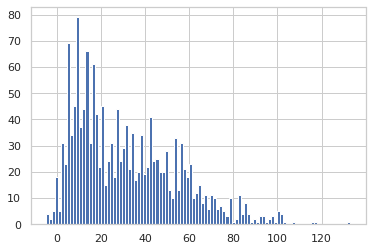

In [8]:
train['Weeks'].hist(bins=100)

In [9]:
train['Weeks'].describe()

count    1549.000000
mean       31.861846
std        23.247550
min        -5.000000
25%        12.000000
50%        28.000000
75%        47.000000
max       133.000000
Name: Weeks, dtype: float64

<AxesSubplot:>

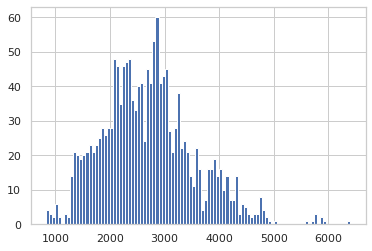

In [10]:
train['FVC'].hist(bins=100)

In [11]:
train['FVC'].describe()

count    1549.000000
mean     2690.479019
std       832.770959
min       827.000000
25%      2109.000000
50%      2641.000000
75%      3171.000000
max      6399.000000
Name: FVC, dtype: float64

# Get last three FVC readings per patient

In [ ]:
rows = []
row = {}
prev = None
last_weeks: Deque[int] = deque()
last_fvc: Deque[float] = deque()
for t in train.itertuples():
    if prev is not None and prev != t.Patient:  # new patient
        if len(last_fvc) < 3:
            pass
        row['fvc_last_1'] = last_fvc[2]
        row['fvc_last_2'] = last_fvc[1]
        row['fvc_last_3'] = last_fvc[0]
        row['week_last_1'] = last_weeks[2]
        row['week_last_2'] = last_weeks[1]
        row['week_last_3'] = last_weeks[0]
        rows.append(row)
        row.clear()
        last_weeks.clear()
        last_fvc.clear()
        row['pid'] = t.Patient
        row['age'] = t.Age
        row['sex'] = t.Sex
        row['smoking'] = t.SmokingStatus
        row['week_1'] = t.Weeks
        row['fvc_1'] = t.FVC
        row['percent_1'] = t.Percent
    last_weeks.append(t.Weeks)
    if len(last_weeks) == 4:
        last_weeks.popleft()
    last_fvc.append(t.FVC)
    if len(last_fvc) == 4:
        last_fvc.popleft()
    
    
train = pd.DataFrame.from_records(rows)
train.info()